In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import tqdm
import albumentations as abm
import torchvision.transforms.functional as TF

class Dataset(Dataset):
    """depth estimation dataset."""

    def __init__(self, img_dir, csv_dir, transform=None):
        """
        Args:
            root_dir (string): Directory containing image folders.
            keyword: examples are "img_train"
        """
        self.img_dir = img_dir
        self.csv_dir = csv_dir
        self.labels = pd.read_csv(self.csv_dir, header = None)
        print("self.labels", self.labels)
        self.transform = transform

        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        # get label
        label = np.reshape(self.labels.iloc[idx,:].values, (2, 2))
        label = label.astype('float')
        
        # get relevant frame
        img_path = os.path.join(self.img_dir, "camera_image_{:06d}".format(idx) + ".jpg")
        image = io.imread(img_path)
        sample = {'image': image, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [2]:
# Data augmentation - Must be applied in the order as follows
class ShiftScaleRotate(object):
    def __init__(self, p = 0.8):
        self.p = p
        self.ssr = abm.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.3, rotate_limit=20,
                                    interpolation=1, border_mode=4,
                                    value=None, mask_value=None,
                                    p=self.p) # always_apply=True
        self.composed_functions = abm.Compose([self.ssr], keypoint_params=abm.KeypointParams(format='xy', remove_invisible=True))

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        transformed = self.composed_functions(image = image, keypoints = label)
        image = transformed['image']
        label = transformed['keypoints']

        return{'image':image,
               'label':label
        }

class RandomSizedBBoxSafeCrop(object):
    """Crop such that the keypoints will be in the bounding box
    To make sure that the tool-tip will be visible, add an extra keypoint
    to the right of the needle (see code below)
    Note: keypoints are not implemented, so use tool-tip as a bounding box param
    """
    def __init__(self, p = 0.8):
        self.p = p
        
        self.category_ids = [0, 1, 2, 3]
        self.ssr = abm.RandomSizedBBoxSafeCrop(width=512, height=512, erosion_rate=0.1, interpolation=1, 
                                               always_apply = True)
        self.centerCrop = abm.CenterCrop (height=512, width =512, always_apply=True)
        
        self.composed_functions = abm.Compose([self.ssr], 
                                bbox_params=abm.BboxParams(format='coco', label_fields=['category_ids']))
        # apply center crop if not performing above aug
        self.composed_functions_alt = abm.Compose([self.centerCrop], 
                                              keypoint_params=abm.KeypointParams(format='xy'))

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
    
        # perform random sized bbox safe crop
        if (np.random.uniform() < self.p):
            transformed = self.composed_functions(image = image, 
                                bboxes = [[label[0][0], label[0][1], 1, 1], 
                                          [label[1][0], label[1][1], 1, 1],
                                          [label[0][0], label[0][1], 4, 4], 
                                          [label[1][0], label[1][1], 4, 4]],
                                category_ids = self.category_ids)
            image = transformed['image']
            label = np.array((transformed['bboxes'][0][0:2], transformed['bboxes'][1][0:2])).reshape(2, 2)
        # otherwise just center crop
        else:
            transformed = self.composed_functions_alt(image = image, keypoints = label)
            image = transformed['image']
            label = transformed['keypoints']
            
        return{'image':image,
               'label':label,
        }
    
class SafeRotate(object):  
    def __init__(self, p = 1):
        self.p = p
        self.ssr = abm.SafeRotate(limit=[90, 90], interpolation=1, 
                                   border_mode=4, value=None, 
                                   mask_value=None, always_apply=True, p=self.p)
        self.composed_functions = abm.Compose([self.ssr], keypoint_params=abm.KeypointParams(format='xy'))      
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        transformed = self.composed_functions(image = image, keypoints = label)
        image = transformed['image']
        label = transformed['keypoints']

        return{'image':image,
               'label':label,
        }

class Crop(object):
    def __init__(self, x_min=0, y_min=0, x_max=700, y_max=500, always_apply = False, p = 1.0):
        self.p = p
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.CenterCrop = abm.Crop(x_min= self.x_min, y_min= self.y_min, x_max= self.x_max, y_max= self.y_max, p = self.p)
        self.composed_functions = abm.Compose([self.CenterCrop], keypoint_params=abm.KeypointParams(format='xy'))
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        transformed = self.composed_functions(image = image, keypoints = label)
        image = transformed['image']
        label = transformed['keypoints']
        
        return{'image':image,
               'label':label
        }
    
class CenterCrop(object):
    def __init__(self, height = 480, width = 640, always_apply = False, p = 1.0):
        self.p = p
        self.height = height
        self.width = width
        self.CenterCrop = abm.CenterCrop(height = self.height, width = self.width, p = self.p)
        self.composed_functions = abm.Compose([self.CenterCrop], keypoint_params=abm.KeypointParams(format='xy'))
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        transformed = self.composed_functions(image = image, keypoints = label)
        image = transformed['image']
        label = transformed['keypoints']
        
        return{'image':image,
               'label':label
        }

class Blur(object):  
    def __init__(self, p = 0.8):
        self.p = p
        self.composed_functions = abm.Compose(
            [abm.Blur(p=self.p)], 
            keypoint_params=abm.KeypointParams(format='xy')
        )
        

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
    
        transformed = self.composed_functions(image = image, keypoints = label)
        image = transformed['image']
        label = transformed['keypoints']
        
        return{'image':image,
               'label':label,
        }

class Jitter(object):
    def __init__(self, p = 0.8):
        self.p = p
        self.jitter = torchvision.transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25)
    
    def __call__(self, sample):
        
        image, label = sample['image'], sample['label']
        
        # jitter 20 percent of the time                                            
        if (np.random.uniform() < self.p):
            image = TF.to_pil_image(image)
            image = self.jitter(image)

            image = np.array(image)
        
        
        return{'image':image,
               'label':label
        }

    
class AddHueSaturationRGBShift(object):  
    def __init__(self, p = 0.8):
        self.p = p
        self.hue_saturation = abm.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20)
        self.rgb_shift = abm.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20)
        self.composed_functions = abm.Compose([self.hue_saturation, self.rgb_shift])
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        # add noise and dropout 20 percent of the time                 
        if (np.random.uniform() < self.p):
            image = {'image': image}
            image = self.composed_functions(**image)
            image = image['image']
        
        
        return{'image':image,
               'label':label
        }
    
class AddNoiseAddDropout(object):  
    def __init__(self, p = 0.8):
        self.p = p
        self.dropout_function = abm.CoarseDropout(max_holes = 140, max_height = 5, 
                                                  max_width = 5, always_apply = True)
        self.noise_function = abm.GaussNoise(always_apply=True)
        self.composed_functions = abm.Compose([self.dropout_function, self.noise_function])
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        # add noise and dropout 20 percent of the time                 
        if (np.random.uniform() < self.p):
            image = {'image': image}
            image = self.composed_functions(**image)
            image = image['image']
        
        
        return{'image':image,
               'label':label
        }

class AddTargetLayer(object):
    """Add a binary target layer to each image."""

    def __call__(self, sample):
        sz = 20
        image, label = [sample['image'], sample['label']]
        target_image = np.zeros((512, 512))
        target_image[int(label[1][1])-sz:int(label[1][1])+sz+1, int(label[1][0])-sz:int(label[1][0])+sz+1] = 1 
        target_image = target_image[:,:,np.newaxis]*255

        # combine inputs
        image = np.concatenate((image, target_image), axis = 2) / 255.0
        
        return{'image':image, 'label': label} 

class ConvertToolTipPositionToImageLabel(object):
    """Convert point labels to class labelss (0 - 7)."""

    def __call__(self, sample):
        image, label = [sample['image'], sample['label']]
        # create label
        label = np.array(label)
        label = label.astype('float')
        v = label[1] - label[0]
        angle = np.arctan2(-v[1], v[0]) * 180 / np.pi
        if angle >= 157.5 and angle <= 180 or angle < -157.5:
            cur_class_label = 0
        else:
            cur_class_label = int((angle + 202.5) / 45)
        if (np.linalg.norm(v) < 2.5):
            cur_class_label = 8
        
        return{'image':image, 'label': label, 'class_label': cur_class_label} 
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, class_label = [sample['image'], sample['label'], sample['class_label']]
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = TF.to_tensor(image)
#         image = image.unsqueeze(0)
        class_label = torch.tensor(class_label)
        
        return{'image':image, 'label': label, 'class_label': class_label} 

In [3]:
# Create Train/Test Dataset
datasets = []
train_datasets = []
validation_datasets = []
# train dataset
data_transform_train = transforms.Compose([
            ShiftScaleRotate(),
            RandomSizedBBoxSafeCrop(),
            Blur(),
            Jitter(),
            AddHueSaturationRGBShift(),
            AddNoiseAddDropout(),
            AddTargetLayer(),
            ConvertToolTipPositionToImageLabel(),
            ToTensor()
            ])

data_transform_validation = transforms.Compose([
            AddTargetLayer(),
            ConvertToolTipPositionToImageLabel(),
            ToTensor()
            ])
train_dataset = Dataset(img_dir = "../dataset_for_all/navigation_network/training_data", csv_dir = "training_tool_tip_and_targets_label.csv",  
                        transform = data_transform_train) #= data_transform)

# test dataset
validation_dataset = Dataset(img_dir = "../dataset_for_all/navigation_network/validation_data", csv_dir = "validation_tool_tip_and_targets_label.csv",  
                       transform = data_transform_validation) #= data_transform)


self.labels            0      1      2      3
0      202.0  309.0  208.0  279.0
1      203.0  308.0  208.0  279.0
2      203.0  309.0  208.0  279.0
3      202.0  309.0  208.0  279.0
4      202.0  310.0  208.0  279.0
...      ...    ...    ...    ...
21595  189.0  286.0  186.0  281.0
21596  188.0  284.0  186.0  281.0
21597  186.0  282.0  186.0  281.0
21598  186.0  281.0  186.0  281.0
21599  187.0  281.0  186.0  281.0

[21600 rows x 4 columns]
self.labels           0      1      2      3
0     235.0  270.0  208.0  279.0
1     265.0  305.0  208.0  279.0
2     204.0  308.0  208.0  279.0
3     291.0  277.0  208.0  279.0
4     225.0  257.0  208.0  279.0
...     ...    ...    ...    ...
5395  264.0  275.0  264.0  275.0
5396  241.0  295.0  237.0  294.0
5397  210.0  302.0  216.0  300.0
5398  232.0  313.0  235.0  313.0
5399  245.0  250.0  237.0  249.0

[5400 rows x 4 columns]


In [4]:
print("training_dataset total images:", len(train_dataset))
print("validation_dataset total images:", len(validation_dataset))
print("training percentage: ", len(train_dataset)/(len(train_dataset) + len(validation_dataset)))
print("validation percentage: ", len(validation_dataset)/(len(train_dataset) + len(validation_dataset)))

training_dataset total images: 21600
validation_dataset total images: 5400
training percentage:  0.8
validation percentage:  0.2


# Check train dataset

index 16200
class_label =  tensor(0)
angle is =  167.10668513119631


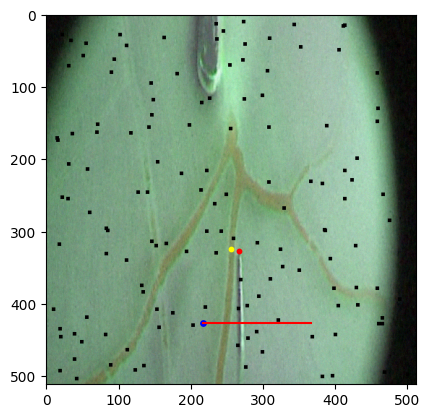

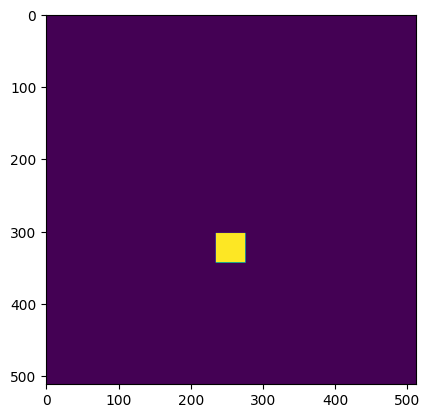

index 16201
class_label =  tensor(0)
angle is =  175.81765719272133


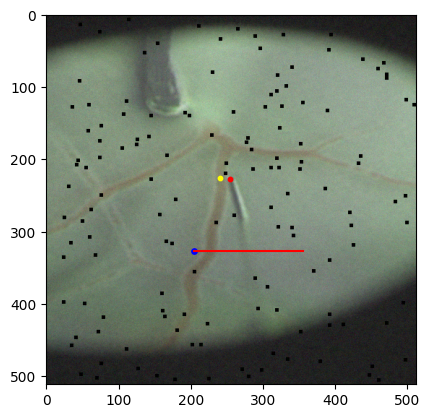

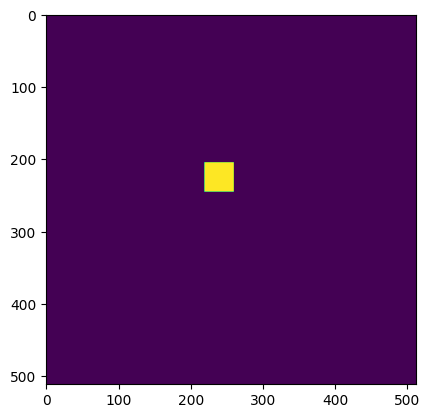

index 16202
class_label =  tensor(0)
angle is =  172.47789054710196


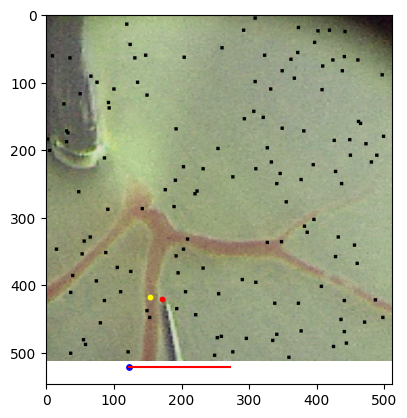

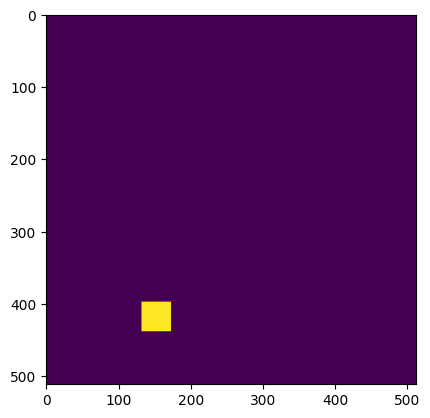

In [5]:
for i in range(16200, 16203):
    print("index", i)
    dataset = train_dataset[i]
    image = dataset['image'].permute(1, 2, 0).numpy()
    label = dataset['label']
    class_label = dataset['class_label']
    print("class_label = ", class_label)
    angle = (45 * class_label - 180) / 180 * np.pi
    vector_x = 150 * np.cos(angle)
    vector_y = 150 * np.sin(angle)
    plt.plot([label[0][0] + 100, label[0][0] + 100 + vector_x], [label[0][1] + 100, label[0][1] + 100 - vector_y], "r-")
    plt.scatter(label[0][0] + 100 + vector_x, label[0][1] + 100 - vector_y, c="b", s = 15)
    print("angle is = ", np.arctan2(label[0][1] - label[1][1], label[1][0] - label[0][0]) * 180 / np.pi)
    plt.imshow(image[:, :, 0:3])
    plt.scatter(label[0][0], label[0][1], c = "red", s = 10)
    plt.scatter(label[1][0], label[1][1], c = "yellow", s = 10)
    plt.show()
    plt.imshow(image[:, :, 3])
    plt.show()

# Check validation dataset

class_label =  tensor(3)
angle is =  -26.56505117707799


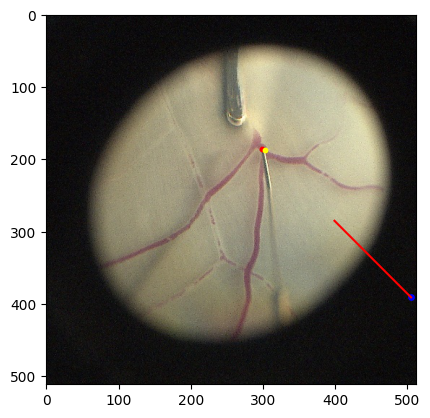

class_label =  tensor(1)
angle is =  -116.56505117707799


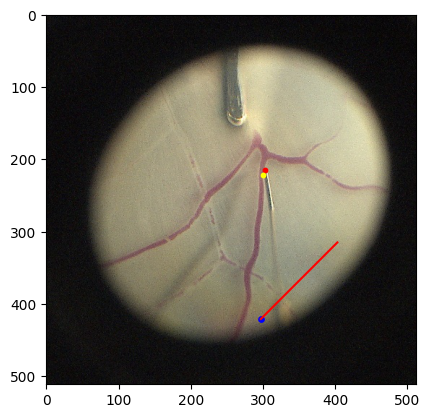

class_label =  tensor(3)
angle is =  -26.56505117707799


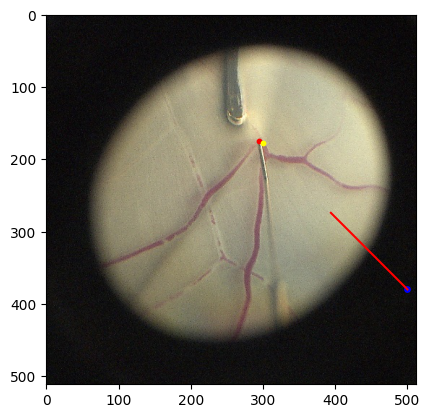

In [6]:
for i in range(4100, 4103):
    dataset = validation_dataset[i]
    image = dataset['image'].permute(1, 2, 0).numpy()
    label = dataset['label']
    class_label = dataset['class_label']
    print("class_label = ", class_label)
    angle = (45 * class_label - 180) / 180 * np.pi
    vector_x = 150 * np.cos(angle)
    vector_y = 150 * np.sin(angle)
    plt.plot([label[0][0] + 100, label[0][0] + 100 + vector_x], [label[0][1] + 100, label[0][1] + 100 - vector_y], "r-")
    plt.scatter(label[0][0] + 100 + vector_x, label[0][1] + 100 - vector_y, c="b", s = 15)
    print("angle is = ", np.arctan2(label[0][1] - label[1][1], label[1][0] - label[0][0]) * 180 / np.pi)
    plt.imshow(image[:, :, 0:3])
    plt.scatter(label[0][0], label[0][1], c = "red", s = 10)
    plt.scatter(label[1][0], label[1][1], c = "yellow", s = 10)
    plt.show()

# Train the Network

In [7]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [8]:
def adjust_learning_rate(optimizer=None, initial_learning_rate=1e-5, epoch=1, total_epochs=500):
    """
    Adjust the learning rate based on the current epoch.
    Args:
        optimizer (torch.optim.Optimizer): The optimizer to adjust the learning rate for.
        initial_learning_rate (int): Default is 1e-5.
        epoch (int): The current epoch number.
        total_epochs (int): Total epochs we want to train.
    """
    # Define the learning rate schedule
    initial_lr = initial_learning_rate
    warmup_epochs = 5
    cosine_decay_epochs = total_epochs

    if epoch < warmup_epochs:
        # Warm-up phase: Linearly increase the learning rate
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine annealing decay: Gradually reduce the learning rate
        progress = (epoch - warmup_epochs) / cosine_decay_epochs
        lr = initial_lr * 0.5 * (1 + np.cos(np.pi * progress))
    # Update the learning rate in the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
# Create resnet18 network
class Resnet_tool_tip_labelling_large(torch.nn.Module):
  """
  input size is 512 x 512 x 4
  """
  def __init__(self, orig_resnet, n_classes=9):
    super().__init__()
    self.orig_resnet = orig_resnet
    self.orig_resnet.avgpool = nn.AvgPool2d(kernel_size=(8,8), stride=(4,4))
    self.orig_resnet.fc = nn.Linear(in_features=3*3*512, out_features=1000)
    self.orig_resnet.out = nn.Linear(in_features=1000, out_features=n_classes)
    
  def forward(self, x):
    # encoder
    x1 = self.orig_resnet.conv1(x) # 64 x 256 x 256
    x2 = self.orig_resnet.bn1(x1) 
    x3 = self.orig_resnet.relu(x2)
    x4 = self.orig_resnet.maxpool(x3) # 64 x 128 x 128
    x5 = self.orig_resnet.layer1(x4) # 64 x 128 x 128
    x6 = self.orig_resnet.layer2(x5) # 128 x 64 x 64
    x7 = self.orig_resnet.layer3(x6) # 256 x 32 x 32
    x8 = self.orig_resnet.layer4(x7) # 512 x 16 x 16
    x9 = self.orig_resnet.avgpool(x8) # 512 x 3 x 3
    x10 = x9.reshape(x9.shape[0], -1) # N x (512 x 3 x 3)
    x11 = self.orig_resnet.relu(self.orig_resnet.fc(x10)) # N x 1000
    x12 = self.orig_resnet.out(x11) # N x 9
    return x12

# Vanilla check

In [10]:
# setup model
print("USING THE FIRST GPU")
device = torch.device("cpu")
print("USING DEVICE", device)

# use volumetric output with skip-connections and more decoders
resnet = models.resnet18(pretrained=False)
n_input_channel = 4
resnet.conv1 = torch.nn.Conv2d(n_input_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft = Resnet_tool_tip_labelling_large(resnet) 
model_ft = model_ft.to(device)

USING THE FIRST GPU
USING DEVICE cpu


/home/peiyao/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/peiyao/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
image = np.zeros((512, 512, 4))
image = TF.to_tensor(image)
image = image.unsqueeze(0).float()
print(image.shape)

torch.Size([1, 4, 512, 512])


In [12]:
result = model_ft(image)
print(result.shape)

torch.Size([1, 9])


In [13]:
# model training function
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25, initial_lr=1e-5, device=None):
    since = time.time()
    
    # initialization every epoch
    best_validation_model_output = None
    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 1000000

    best_acc = -1000

    train_losses = [] 
    test_losses = []
    final_accuracies = []
    
    running_loss_avg = None
    all_info = []
    # no need to resample test loader every epoch
    val_dataloader = DataLoader(validation_dataset, batch_size = 128, shuffle = False)
    for epoch in range(num_epochs):
        adjust_learning_rate(optimizer, initial_lr, epoch, num_epochs)
        # sample from dataloader every epoch
        train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
        dataloaders = {'train': train_dataloader, 'val': val_dataloader}
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        error_per_sample_for_epoch = 0.0
        for phase in ['train', 'val']:
    
            running_loss = 0.0
            running_loss_avg = 0.0
            absolute_error_list = []
            absolute_error_list_x = []
            absolute_error_list_y = []
            absolute_error_list_z = []
            
            model_outputs = []
            
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode   

            # Iterate over data.
            progress_bar = tqdm.tqdm(dataloaders[phase], desc=phase)
            for batch_idx, data in enumerate(progress_bar):
                inputs = data['image'].to(device).float()
                labels = data['label'].to(device)
                class_labels = data['class_label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(inputs)
                    loss = criterion(output, class_labels)
                    # calculate error
                    output_np = output.cpu().detach().numpy()
                    for i in range(len(output_np)):
                        # get current output
                        a = output_np[i,:]
                        # find the argmax and reshape into xy coords
                        current_argmax = a.argmax()
                        # get the correct xy coords
                        cur_class_label = class_labels[i].cpu().detach().numpy()
                        error = np.absolute(current_argmax - cur_class_label)
                        if (cur_class_label == 8 and current_argmax != 8):
                            error = 4
                        elif (error > 4):
                            error = 8 - error
                        
                        absolute_error_list.append(error)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Loss
                running_loss += loss.item() 
                running_loss_avg = running_loss / (batch_idx + 1)
                running_error = np.sum(absolute_error_list) / len(absolute_error_list)

                progress_bar.set_description(
                'loss avg by batch: {:.4}, running_abs_error: {:.2f}'.format(
                    running_loss / (batch_idx + 1), running_error) )
            
            # record train/test loss
            if phase == 'train':
                train_losses.append(running_loss)
                all_info.append([epoch, "train", running_error])
                
            if phase == 'val':
                test_losses.append(running_loss)
                all_info.append([epoch, "val", running_error])
            
        # per epoch loop
        # save model_parameters every epoch
        if not os.path.exists("./training_parameters"):
            os.makedirs("./training_parameters")
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer':optimizer.state_dict()},
                       "./training_parameters/epoch_" + str(epoch) + phase + "_checkpoint.pth.tar")

        np.savetxt("progress_log.csv", np.asarray(all_info), delimiter=",", fmt="%s")

        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_validation_model_output, train_losses, test_losses

In [14]:
import warnings; warnings.simplefilter('ignore')
import cv2
import random 
# setup model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = models.resnet18(pretrained=False)
n_input_channel = 4
resnet.conv1 = torch.nn.Conv2d(n_input_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# choose resnet of your choice
resnet_enc_dec_concat_more = Resnet_tool_tip_labelling_large(resnet)
# resnet_enc_dec_concat_more = nn.DataParallel(resnet_enc_dec_concat_more)
model_ft = resnet_enc_dec_concat_more.to(device)
# choose criteria
criterion = nn.CrossEntropyLoss()
# criterion2 = nn.MSELoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.003)
# LODA OPTIMIZER PARAM
#optimizer_ft.load_state_dict(checkpoint['optimizer'])

# model_ft, best_validation_model_output, train_losses, test_losses, predicted_imgs = train_model(
#             model = model_ft,
#             criterion1 = criterion1, criterion2 = criterion2,
#             optimizer = optimizer_ft,
#             num_epochs= 50, 
#             device=device)

cuda:0


In [15]:
# camera image training - 27000 images - aggressive augmentation - 9 classes - lr 0.003 best 178
model_ft, best_validation_model_output, train_losses, test_losses = train_model(
            model = model_ft,
            criterion = criterion,
            optimizer = optimizer_ft,
            num_epochs = 200,
            initial_lr = 0.003,
            device=device)

Epoch 0/199
----------


loss avg by batch: 2.269, running_abs_error: 2.14: 100%|█| 169/169 [18:41<00:00,
loss avg by batch: 2.171, running_abs_error: 2.05: 100%|█| 43/43 [01:03<00:00,  


Epoch 1/199
----------


loss avg by batch: 2.183, running_abs_error: 2.10:   4%| | 6/169 [00:43<19:42,  


KeyboardInterrupt: 